# Predicting House Prices

### IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import pickle
%matplotlib inline

print('Libraries Imported')

Libraries Imported


### READING DATA

In [2]:
data=pd.read_csv('Bengaluru_House_Data.csv')

In [3]:
data.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### RENAMING A COLUMN

In [4]:
data.rename(columns={'size':'BHK'},inplace=True)

### FINDING NA & DUPLICATES

In [5]:
data.isna().sum()

area_type          0
availability       0
location           1
BHK               16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [6]:
data.duplicated().sum()

529

In [7]:
data = data.drop_duplicates()

### REMOVING UN-REQUIRED COLUMNS

In [8]:
data.drop("society",axis=1,inplace=True)

### DEALING WITH NA

In [9]:
data['balcony'] = (data['balcony'].fillna(value=data['balcony'].median())).astype(int)
data.dropna(inplace=True)

In [10]:
data.head()

,area_type,availability,location,BHK,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1,51.00


In [11]:
data.isna().sum()

area_type       0
availability    0
location        0
BHK             0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

### DATA PREPROCESSING

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12717 entries, 0 to 13318
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     12717 non-null  object 
 1   availability  12717 non-null  object 
 2   location      12717 non-null  object 
 3   BHK           12717 non-null  object 
 4   total_sqft    12717 non-null  object 
 5   bath          12717 non-null  float64
 6   balcony       12717 non-null  int32  
 7   price         12717 non-null  float64
dtypes: float64(2), int32(1), object(5)
memory usage: 844.5+ KB


In [13]:
data['BHK'] = data['BHK'].apply(lambda x : int(x.split(' ')[0]))

In [14]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True
    
data[~data['total_sqft'].apply(is_float)].head(10)#to show inappropriate data

,area_type,availability,location,BHK,total_sqft,bath,balcony,price
30,Super built-up Area,19-Dec,Yelahanka,4,2100 - 2850,4.0,0,186.000
122,Super built-up Area,18-Mar,Hebbal,4,3067 - 8156,4.0,0,477.000
137,Super built-up Area,19-Mar,8th Phase JP Nagar,2,1042 - 1105,2.0,0,54.005
165,Super built-up Area,18-Dec,Sarjapur,2,1145 - 1340,2.0,0,43.490
188,Super built-up Area,Ready To Move,KR Puram,2,1015 - 1540,2.0,0,56.800
410,Super built-up Area,Ready To Move,Kengeri,1,34.46Sq. Meter,1.0,0,18.500
549,Super built-up Area,18-Sep,Hennur Road,2,1195 - 1440,2.0,0,63.770
648,Built-up Area,Ready To Move,Arekere,9,4125Perch,9.0,2,265.000
661,Super built-up Area,Ready To Move,Yelahanka,2,1120 - 1145,2.0,0,48.130
672,Built-up Area,18-Mar,Bettahalsoor,4,3090 - 5002,4.0,0,445.000


In [15]:
def convert_sqft_to_num(x):
    token = x.split('-')
    if len(token)==2:
        return (float(token[0]) + float(token[1]))/2
    try:
        return float(x)
    except:
        return None
data['total_sqft'] = data['total_sqft'].apply(convert_sqft_to_num)

In [16]:
def avail(input):
    if(input=="Ready To Move"):
        return 0
    else:
        return 1
data['availability'] = data['availability'].apply(avail)

In [17]:
sum=data.groupby('location')['location'].agg('count')
sum

location
 Anekal                 1
 Banaswadi              1
 Basavangudi            1
 Bhoganhalli            1
 Devarabeesana Halli    6
                       ..
t.c palya               1
tc.palya                4
vinayakanagar           1
white field,kadugodi    1
whitefiled              1
Name: location, Length: 1304, dtype: int64

In [18]:
data.location.value_counts()

Whitefield              517
Sarjapur  Road          372
Electronic City         287
Kanakpura Road          242
Thanisandra             228
                       ... 
Shettihalli               1
Sadhguru Layout           1
3rd Phase Iti Layout      1
Richmond Road             1
Fraser town               1
Name: location, Length: 1304, dtype: int64

In [19]:
data.location = data.location.apply(lambda x: x.strip()) # remove leading or end spaces
location_stats_less_than_10 = sum[sum<=10]
data.location = data.location.apply(lambda x : 'other' if x in location_stats_less_than_10 else x)

In [20]:
location = data.location.unique()
pickle.dump(location, open('models/location.pkl','wb'))
area = data.area_type.unique()
pickle.dump(area, open('models/area.pkl','wb'))
#area_encoder = preprocessing.LabelEncoder()
#location_encoder = preprocessing.LabelEncoder()
#area_type = area_encoder.fit_transform(sorted(data['area_type']))
#location = location_encoder.fit_transform(sorted(data['location']))

In [21]:
data.isna().sum()

area_type        0
availability     0
location         0
BHK              0
total_sqft      46
bath             0
balcony          0
price            0
dtype: int64

In [22]:
data = data.dropna()
data.isna().sum()

area_type       0
availability    0
location        0
BHK             0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

### FINDING CORRELATIONS

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12671 entries, 0 to 13318
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     12671 non-null  object 
 1   availability  12671 non-null  int64  
 2   location      12671 non-null  object 
 3   BHK           12671 non-null  int64  
 4   total_sqft    12671 non-null  float64
 5   bath          12671 non-null  float64
 6   balcony       12671 non-null  int32  
 7   price         12671 non-null  float64
dtypes: float64(3), int32(1), int64(2), object(2)
memory usage: 841.4+ KB


In [24]:
corr_matrix = data.corr()
corr_matrix

,availability,BHK,total_sqft,bath,balcony,price
availability,1.000000,-0.104096,-0.025646,-0.074418,-0.119748,-0.036629
BHK,-0.104096,1.000000,0.342760,0.898921,0.190847,0.393709
total_sqft,-0.025646,0.342760,1.000000,0.389167,0.151365,0.572788
bath,-0.074418,0.898921,0.389167,1.000000,0.205829,0.452750
balcony,-0.119748,0.190847,0.151365,0.205829,1.000000,0.123284
price,-0.036629,0.393709,0.572788,0.452750,0.123284,1.000000


In [25]:
corr_matrix['price'].sort_values(ascending=False)

price           1.000000
total_sqft      0.572788
bath            0.452750
BHK             0.393709
balcony         0.123284
availability   -0.036629
Name: price, dtype: float64

<AxesSubplot:>

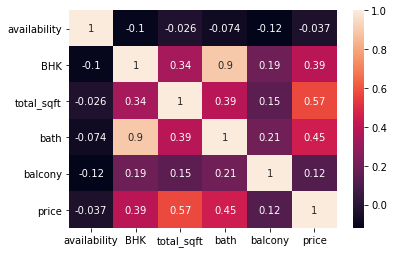

In [26]:
sns.heatmap(data.corr(), annot=True)

In [27]:
data.drop(columns=['availability'],axis=1,inplace=True)
data['price_per_sqft'] = data['price']*1000/data['total_sqft']
data['bath_per_BHK'] = data['bath']/data['BHK']
data = data.dropna()
data.head()

,area_type,location,BHK,total_sqft,bath,balcony,price,price_per_sqft,bath_per_BHK
0,Super built-up Area,Electronic City Phase II,2,1056.0,2.0,1,39.07,36.998106,1.000000
1,Plot Area,Chikka Tirupathi,4,2600.0,5.0,3,120.00,46.153846,1.250000
2,Built-up Area,Uttarahalli,3,1440.0,2.0,3,62.00,43.055556,0.666667
3,Super built-up Area,Lingadheeranahalli,3,1521.0,3.0,1,95.00,62.458909,1.000000
4,Super built-up Area,Kothanur,2,1200.0,2.0,1,51.00,42.500000,1.000000


### DETECTING & REMOVING OUTLIERS

In [28]:
#sns.boxplot('area_type', data=data, orient = 'horizontal')

<AxesSubplot:xlabel='total_sqft'>

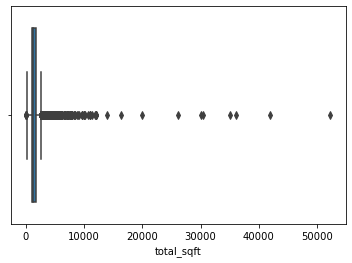

In [29]:
sns.boxplot('total_sqft', data=data, orient = 'horizontal')

<AxesSubplot:xlabel='BHK'>

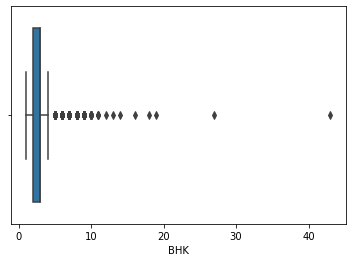

In [30]:
sns.boxplot('BHK', data = data, orient = 'horizontal')

<AxesSubplot:xlabel='bath'>

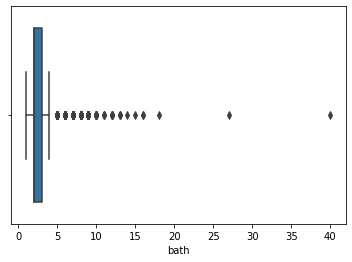

In [31]:
sns.boxplot('bath', data = data, orient = 'horizontal')

<AxesSubplot:xlabel='price'>

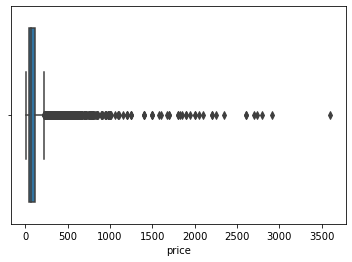

In [32]:
sns.boxplot('price', data=data, orient = 'price')

In [33]:
#Since average 1BHK have atleast 300 sqft so removing those having less
#BHK also had some only bedroom so indirectly removing them
data = data[~(data.total_sqft/data.BHK <300)] 

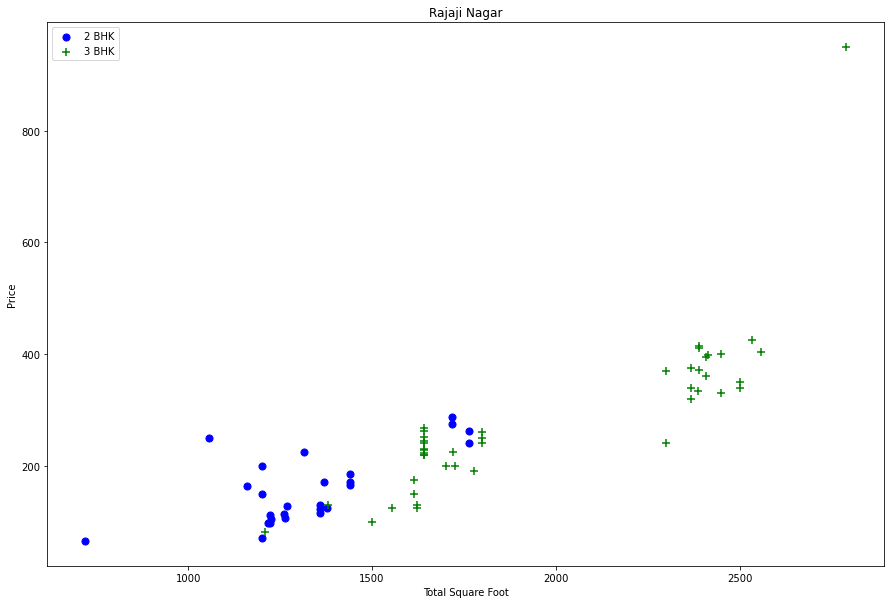

In [34]:
import matplotlib.pyplot as plt
def plot_scatter_chart(df,location):
    bhk2=df[(df.location==location)&(df.BHK==2)]
    bhk3=df[(df.location==location)&(df.BHK==3)]
    plt.rcParams['figure.figsize']=(15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='Blue',label='2 BHK',s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,color='green',marker='+',label='3 BHK',s=50)
    plt.xlabel('Total Square Foot')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()
plot_scatter_chart(data,"Rajaji Nagar")

In [35]:
def remove_bhk_outliers(df):
    exclude_indices=np.array([])
    for location, location_df in df.groupby('location'):
        bhk_sats={}
        for BHK,BHK_df in location_df.groupby('BHK'):
            bhk_sats[BHK]={
                'mean':np.mean(BHK_df.price_per_sqft),
                'std':np.std(BHK_df.price_per_sqft),
                'count':BHK_df.shape[0]
            }
        for BHK,BHK_df in location_df.groupby('BHK'):
            stats=bhk_sats.get(BHK-1)
            if stats and stats['count']>5:
                exclude_indices=np.append(exclude_indices,BHK_df[BHK_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

data=remove_bhk_outliers(data)

In [36]:
#data['zscore_bhk'] = ( data.BHK - data.BHK.mean() ) / data.BHK.std()
#data['zscore_bath'] = ( data.bath - data.bath.mean() ) / data.bath.std()
#data['zscore_total_sqft'] = ( data.total_sqft - data.total_sqft.mean() ) / data.total_sqft.std()
#data['zscore_price'] = ( data.price - data.price.mean() ) / data.price.std()
data['zscore_price_per_sqft'] = ( data.price_per_sqft - data.price_per_sqft.mean() ) / data.price_per_sqft.std()
data['zscore_bath_per_bhk'] = ( data.bath_per_BHK - data.bath_per_BHK.mean() ) / data.bath_per_BHK.std()

In [37]:
#data = data[(data.zscore_bhk>-3) & (data.zscore_bhk<3)]
#data = data[(data.zscore_bath>-3) & (data.zscore_bath<3)]
#data = data[(data.zscore_total_sqft>-3) & (data.zscore_total_sqft<3)]
#data = data[(data.zscore_price>-3) & (data.zscore_price<3)]
data = data[(data.zscore_price_per_sqft>-3) & (data.zscore_price_per_sqft<3)]
data = data[(data.zscore_bath_per_bhk>-3) & (data.zscore_bath_per_bhk<3)]

<AxesSubplot:xlabel='total_sqft'>

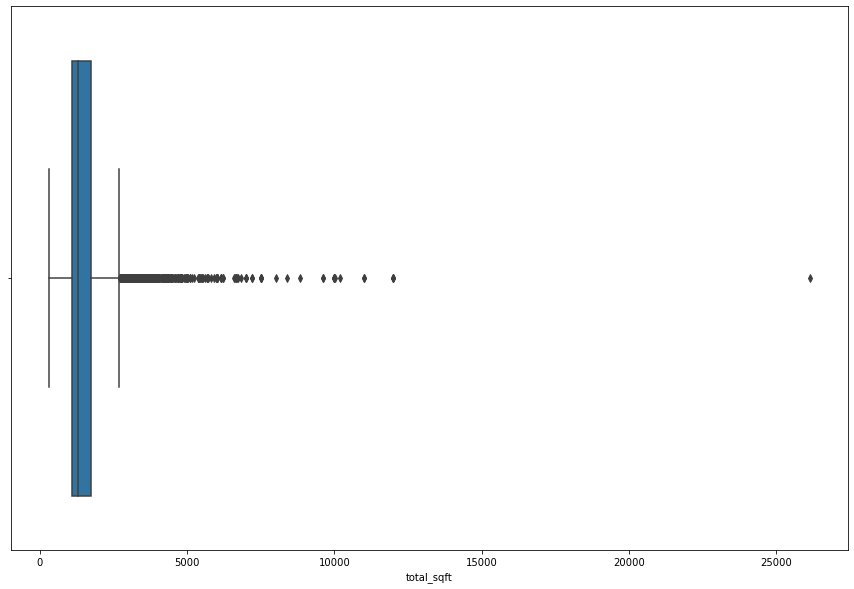

In [38]:
sns.boxplot('total_sqft', data=data, orient = 'horizontal')

<AxesSubplot:xlabel='BHK'>

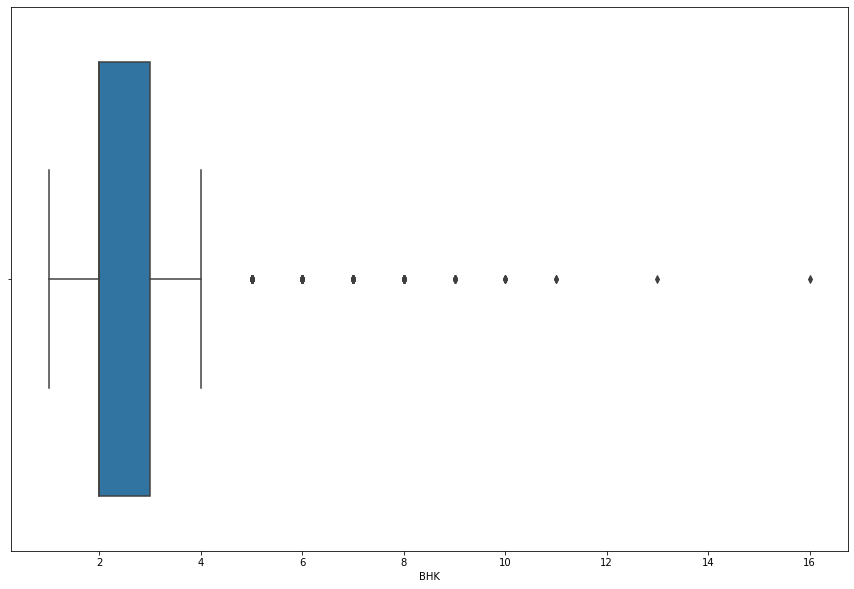

In [39]:
sns.boxplot('BHK', data = data, orient = 'horizontal')

<AxesSubplot:xlabel='bath'>

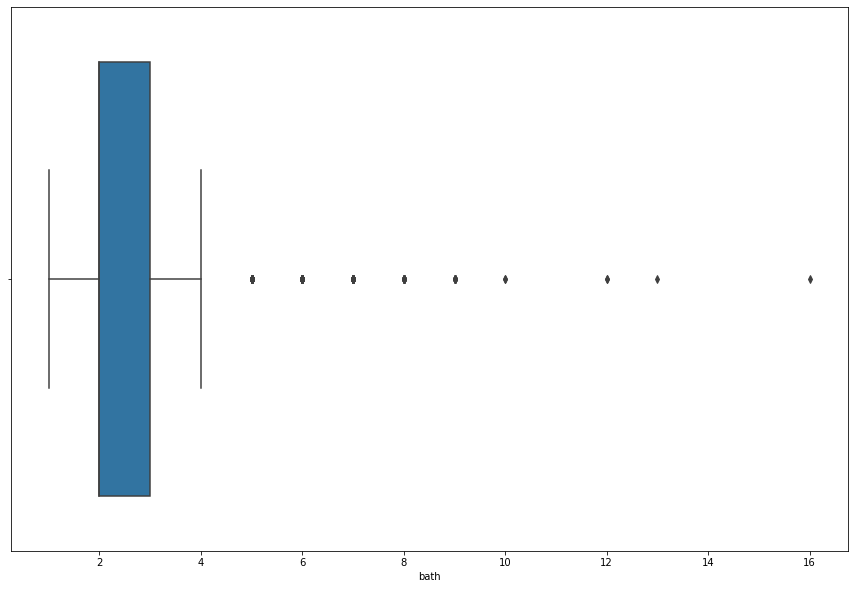

In [40]:
sns.boxplot('bath', data = data, orient = 'horizontal')

<AxesSubplot:xlabel='price'>

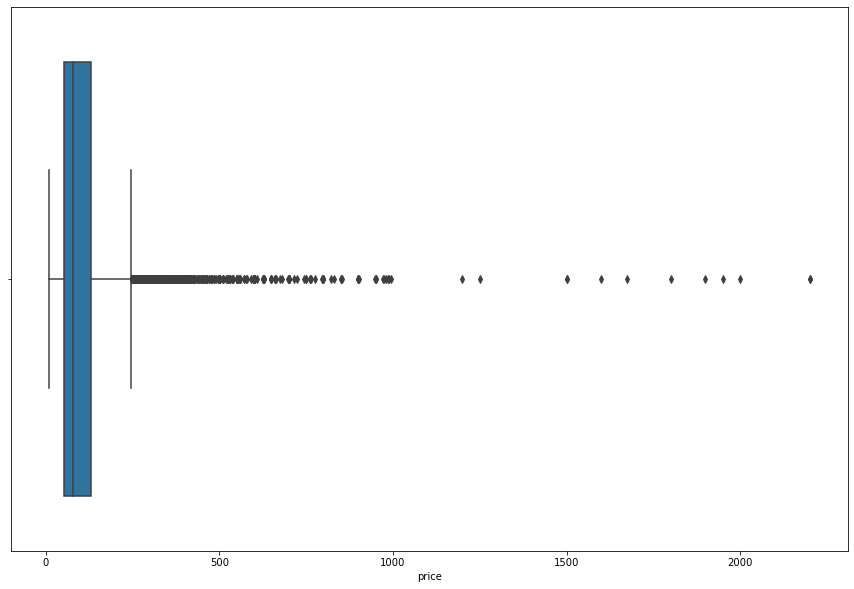

In [41]:
sns.boxplot('price', data=data, orient = 'price')

In [42]:
X = data.drop(columns=['price','zscore_price_per_sqft','price_per_sqft','bath_per_BHK','zscore_bath_per_bhk','area_type','location'])
#X = data.drop(columns=['price','zscore_bhk','zscore_bath','zscore_total_sqft','zscore_price','zscore_price_per_sqft','price_per_sqft','bath_per_BHK','zscore_bath_per_bhk'])
#data.drop("location",axis=1,inplace=True)
#data.rename(columns={'locat':'location'},inplace=True)
#X.rename(columns={'locat':'location'},inplace=True)
X.head()

,BHK,total_sqft,bath,balcony
0,2,1056.0,2.0,1
2,3,1440.0,2.0,3
3,3,1521.0,3.0,1
4,2,1200.0,2.0,1
6,4,2732.0,4.0,2


### USING ONE HOT ENCODER

In [43]:
ohe = OneHotEncoder(drop='first')
print(X.head())
X_trans = ohe.fit_transform(data[['area_type','location']]).toarray()
X = np.hstack((X,X_trans))

   BHK  total_sqft  bath  balcony
0    2      1056.0   2.0        1
2    3      1440.0   2.0        3
3    3      1521.0   3.0        1
4    2      1200.0   2.0        1
6    4      2732.0   4.0        2


### EXTRACTING LABELS

In [44]:
y = data['price']

In [45]:
y.shape

(8095,)

### STANDARDRIZATION

In [46]:
#Not Standarazing since model is showing already good results
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

### CREATING TRAIN & TEST SET

In [47]:
X_train, X_test,y_train, y_test  = train_test_split(X,y, test_size=0.2)

### CREATING MODEL

In [48]:
#model = LinearRegression()
#model = DecisionTreeRegressor()
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

### EVALUATING MODEL

In [49]:
y_pred = model.predict(X_test)

In [50]:
r2_score(y_test,y_pred)

0.8488486128229765

In [51]:
mean_squared_error(y_test, y_pred, squared=False)

54.6633931772184

### CROSS VALIDATION

In [52]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(model, X, y, cv=cv)

array([0.84839424, 0.81939084, 0.8482125 , 0.81814575, 0.78145868])

In [53]:
scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

def print_scores(scores):
    print("Scores:", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())
print_scores(rmse_scores)

Scores: [48.759518   56.22239175 56.48502308 80.61274944 45.26388172 60.04121825
 43.03757107 55.11442523 67.8552403  80.01897519]
Mean:  59.341099402439156
Standard deviation:  12.508915408792342


### SAVING THE MODEL

In [54]:
filename = 'models/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [55]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8488486128229765


In [56]:
data.area_type.value_counts()

Super built-up  Area    5527
Built-up  Area          1510
Plot  Area              1003
Carpet  Area              55
Name: area_type, dtype: int64

In [57]:
#pickle.dump(area_encoder, open('models/area_encoder.pkl','wb'))
#pickle.dump(location_encoder, open('models/location_encoder.pkl','wb'))

In [58]:
pickle.dump(ohe, open('models/ohe.pkl','wb'))